# **🧰 Step 0 — Setup (Install & Imports)**

In [1]:
# If you're in Google Colab, these should be fine. Rerun if installation takes too long or errors once.
!pip -q install networkx bs4 ipywidgets matplotlib scikit-learn pyvis
!pip -q install rank_bm25
# Enable widgets in Colab
from google.colab import output
output.enable_custom_widget_manager()


# Imports
import re
import math
import json
import time
import queue
import joblib
import random
import urllib.parse as urlparse
from collections import defaultdict, deque

import requests
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from IPython.display import display, HTML
import ipywidgets as widgets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.5 MB/s eta 0:00:00


# **⚙️ Step 1 — Configuration**

In [2]:
# ======= CONFIG (expanded seed list) =======
ONLINE_CRAWL = True

# You can comment/uncomment groups as you like.
SEED_URLS = [
     "https://en.wikipedia.org/wiki/PageRank",
    "https://en.wikipedia.org/wiki/HITS_algorithm",
    "https://en.wikipedia.org/wiki/Web_search_engine",
    "https://en.wikipedia.org/wiki/Web_mining"
    # --- Core “video game” hubs / encyclopedias ---
    "https://en.wikipedia.org/wiki/Video_game",
    "https://en.wikipedia.org/wiki/List_of_best-selling_video_games",
    "https://en.wikipedia.org/wiki/Garena_Free_Fire",
    "https://freefire.fandom.com/wiki/Free_Fire_Wiki",
    "https://en.wikipedia.org/wiki/Battle_royale_game",

    # --- Official / platform pages (some may throttle; keep a few only) ---
    "https://ff.garena.com/",                               # Free Fire official
    "https://www.playstation.com/en-us/games/",
    "https://www.xbox.com/en-US/games/all-games",
    "https://www.nintendo.com/us/store/games/",
    "https://store.steampowered.com/search/?category1=998", # Steam search (PC)
    "https://store.epicgames.com/en-US/",

    # --- Big gaming media & review sites ---
    "https://www.ign.com/",
    "https://www.ign.com/search?q=free+fire",
    "https://www.gamespot.com/",
    "https://www.gamespot.com/search/?q=free%20fire",
    "https://www.pcgamer.com/",
    "https://www.eurogamer.net/",
    "https://kotaku.com/",
    "https://www.polygon.com/gaming",
    "https://www.rockpapershotgun.com/",
    "https://gamerant.com/",
    "https://www.gameinformer.com/",
    "https://www.metacritic.com/browse/game/all/all/all-deals/",

    # --- Wikis / community knowledge (tend to be crawl-friendly) ---
    "https://www.fandom.com/topics/games",
    "https://freefire.fandom.com/wiki/Category:Guides",

    # --- App stores (often indexed pages) ---
    "https://play.google.com/store/search?q=free%20fire&c=apps",
    "https://apps.apple.com/us/search?term=free%20fire",
]

MAX_PAGES = 180                 # Try 120–250; adjust based on runtime and throttling
SAME_DOMAIN_ONLY = False        # << allow the crawler to go beyond a single domain
CRAWL_TIMEOUT = 12
RESPECT_PAUSE = (0.8, 1.8)      # be polite; some sites throttle
USER_AGENT = "MiniSearchEngine-Colab/1.1 (academic demo)"
SAVE_PREFIX = "mini_search_engine_games"
RANK_COMBINE_ALPHA = 0.7
TOPK_RESULTS = 10


# **🔗 Step 2 — URL & HTML Utilities**

In [3]:
def normalize_url(u: str) -> str:
    """Normalize URL by stripping fragments, normalizing scheme/host, and removing trailing '#...'."""
    u = u.strip()
    parsed = urlparse.urlparse(u)
    if not parsed.scheme:
        return ""
    # remove fragments
    parsed = parsed._replace(fragment="")
    # normalize scheme & host to lowercase
    netloc = parsed.netloc.lower()
    scheme = parsed.scheme.lower()
    # remove default ports
    if netloc.endswith(":80") and scheme == "http":
        netloc = netloc[:-3]
    if netloc.endswith(":443") and scheme == "https":
        netloc = netloc[:-4]
    parsed = parsed._replace(netloc=netloc, scheme=scheme)
    return urlparse.urlunparse(parsed)

def same_domain(url, allowed_roots):
    try:
        host = urlparse.urlparse(url).netloc
        return any(host.endswith(root) for root in allowed_roots)
    except:
        return False

def get_allowed_roots(urls):
    roots = set()
    for u in urls:
        try:
            roots.add(urlparse.urlparse(u).netloc)
        except:
            pass
    return sorted(roots)

def is_html_response(resp):
    ctype = resp.headers.get("Content-Type", "")
    return "text/html" in ctype or "application/xhtml+xml" in ctype

def clean_text(soup: BeautifulSoup) -> str:
    # Remove script/style
    for tag in soup(["script", "style", "noscript", "header", "footer", "aside", "svg"]):
        tag.decompose()
    text = soup.get_text(separator=" ")
    text = re.sub(r"\s+", " ", text).strip()
    return text

def extract_links(base_url, soup: BeautifulSoup):
    links = set()
    for a in soup.find_all("a", href=True):
        href = a["href"]
        # Skip mailto, javascript
        if href.startswith(("mailto:", "javascript:", "#")):
            continue
        abs_url = urlparse.urljoin(base_url, href)
        norm = normalize_url(abs_url)
        if norm:
            links.add(norm)
    return list(links)

def polite_get(url, timeout=10):
    try:
        headers = {"User-Agent": USER_AGENT}
        resp = requests.get(url, headers=headers, timeout=timeout)
        return resp
    except requests.RequestException:
        return None


# **🕷️ Step 3 — Crawler (BFS over seed URLs)**

In [4]:
def crawl(
    seeds,
    max_pages=50,
    same_domain_only=True,
    min_text_chars=400,      # skip near-empty pages
    en_only=True,            # keep English-only when lang is detectable
    per_domain_cap=60        # avoid one domain dominating the crawl
):
    """Return: {url: {'title': str, 'text': str, 'outlinks': [urls]}}"""
    allowed_roots = get_allowed_roots(seeds)
    visited = set()
    domain_counts = defaultdict(int)
    pages = {}

    q = deque()
    for s in seeds:
        norm = normalize_url(s)
        if norm:
            q.append(norm)

    while q and len(visited) < max_pages:
        url = q.popleft()
        if not url or url in visited:
            continue
        if same_domain_only and not same_domain(url, allowed_roots):
            continue

        # per-domain cap
        host = urlparse.urlparse(url).netloc.lower()
        if domain_counts[host] >= per_domain_cap:
            continue

        resp = polite_get(url, timeout=CRAWL_TIMEOUT)
        time.sleep(random.uniform(*RESPECT_PAUSE))

        # basic guards
        if resp is None or not resp.ok or not is_html_response(resp):
            continue
        if resp.text is None or len(resp.text) < 100:
            continue

        visited.add(url)
        domain_counts[host] += 1

        try:
            soup = BeautifulSoup(resp.text, "html.parser")
        except Exception:
            continue

        # Optional: skip noindex pages
        try:
            meta_robots = soup.find("meta", attrs={"name": "robots"})
            if meta_robots and "noindex" in (meta_robots.get("content") or "").lower():
                continue
        except Exception:
            pass

        # Safe title extraction
        try:
            title = soup.title.string.strip() if (soup.title and soup.title.string) else url
        except Exception:
            title = url

        # Text + light quality filters
        text = clean_text(soup)
        if len(text) < min_text_chars:
            continue
        if en_only:
            html_lang = (soup.html.get("lang", "") if soup.html else "").lower()
            if html_lang and not (html_lang.startswith("en") or html_lang.startswith("en-")):
                continue

        # Extract and sanitize outlinks
        raw_out = extract_links(url, soup)
        outlinks = []
        for v in raw_out:
            # keep only http/https
            scheme = urlparse.urlparse(v).scheme
            if scheme not in ("http", "https"):
                continue
            # respect same-domain-only if set
            if same_domain_only and not same_domain(v, allowed_roots):
                continue
            outlinks.append(v)

        # record
        pages[url] = {
            "title": title,
            "text": text,
            "outlinks": outlinks
        }

        # enqueue
        for v in outlinks:
            if v not in visited:
                q.append(v)

    # close the graph
    all_urls = set(pages.keys())
    for u, rec in pages.items():
        rec["outlinks"] = [v for v in rec["outlinks"] if v in all_urls]
    return pages


# **📦 Step 4 — Offline Demo Dataset (No Internet Mode)**

In [5]:
def offline_demo_pages():
    # Minimal synthetic "web"
    data = {
        "https://demo.local/a": {
            "title": "Intro to Web Mining",
            "text": "Web mining includes content mining, link mining, and usage mining. PageRank and HITS are link analysis algorithms.",
            "outlinks": ["https://demo.local/b", "https://demo.local/c"]
        },
        "https://demo.local/b": {
            "title": "PageRank Basics",
            "text": "PageRank uses the link structure of the web as a vote of importance. It assigns higher rank to pages with many inlinks from important pages.",
            "outlinks": ["https://demo.local/c"]
        },
        "https://demo.local/c": {
            "title": "HITS Algorithm",
            "text": "HITS computes authorities and hubs. Authorities are pointed to by good hubs; hubs point to good authorities.",
            "outlinks": ["https://demo.local/a"]
        },
        "https://demo.local/d": {
            "title": "Search Engines",
            "text": "Search engines index documents and rank results using text relevance and link-based measures.",
            "outlinks": ["https://demo.local/a", "https://demo.local/b"]
        }
    }
    return data


# **🌐 Step 5 — Run Crawl or Load Offline**

In [6]:
if ONLINE_CRAWL:
    print("Crawling… (this may take a few minutes)")
    pages = crawl(SEED_URLS, max_pages=MAX_PAGES, same_domain_only=SAME_DOMAIN_ONLY)
    print(f"Crawled {len(pages)} pages.")
else:
    pages = offline_demo_pages()
    print(f"Loaded offline demo dataset with {len(pages)} pages.")

# DataFrame for convenience
df_pages = pd.DataFrame([
    {"url": u, "title": r["title"], "text_len": len(r["text"])}
    for u, r in pages.items()
]).sort_values("url").reset_index(drop=True)

df_pages.head(10)


Crawling… (this may take a few minutes)
Crawled 153 pages.


,url,title,text_len
0,http://bradlove.org/blog/cogsci-page-rank,How a CogSci undergrad invented PageRank three...,4604
1,http://dbpubs.stanford.edu:8090/pub/1998-51,Efficient Crawling Through URL Ordering - Stan...,1731
2,http://dbpubs.stanford.edu:8091/diglib/pub/pro...,About Google!,752
3,http://googleblog.blogspot.com/2005/01/prevent...,Official Google Blog: Preventing comment spam,1996
4,http://research.microsoft.com/pubs/66874/qd-pa...,"Microsoft Research – Emerging Technology, Comp...",1707
5,http://searchengineland.com/google-toolbar-pag...,Google Toolbar PageRank officially goes dark,3566
6,http://searchengineland.com/what-is-google-pag...,What Is Google PageRank? A Guide For Searchers...,22859
7,http://www.mattcutts.com/blog/how-to-report-pa...,How to report paid links,642803
8,http://www.mattcutts.com/blog/pagerank-sculpting/,PageRank sculpting,290596
9,http://www.mattcutts.com/blog/seo-for-bloggers/,Straight from Google: What You Need to Know,68713


# **🔧 Step 6 — Build Graph, Compute PageRank & HITS**

In [7]:
def build_graph(pages):
    G = nx.DiGraph()
    for u, rec in pages.items():
        G.add_node(u, title=rec["title"])
        for v in rec["outlinks"]:
            G.add_edge(u, v)
    return G

def to_rank_dict(values):
    # Normalize to [0,1] for mixing with content scores
    if not values:
        return {}
    arr = np.array(list(values.values()), dtype=float)
    if np.all(arr == 0):
        norm = arr
    else:
        norm = (arr - arr.min()) / (arr.max() - arr.min() + 1e-12)
    return {k: float(v) for k, v in zip(values.keys(), norm)}

G = build_graph(pages)

# PageRank
pagerank_raw = nx.pagerank(G, alpha=0.85) if len(G) else {}
pagerank_norm = to_rank_dict(pagerank_raw)

# HITS (authorities & hubs)
try:
    hits_hubs_raw, hits_auth_raw = nx.hits(G, max_iter=1000, tol=1e-08, normalized=True)
    hits_hubs = to_rank_dict(hits_hubs_raw)
    hits_auth = to_rank_dict(hits_auth_raw)
except nx.PowerIterationFailedConvergence:
    hits_hubs, hits_auth = {}, {}
    print("HITS did not converge on this graph (rare for small graphs).")

# Show top nodes by each metric
def topk(d, k=10):
    return sorted(d.items(), key=lambda x: x[1], reverse=True)[:k]

print("Top PageRank:")
for u, s in topk(pagerank_raw, 5):
    print(f"{s:.4f}  {pages[u]['title'][:60]}  ({u})")

print("\nTop HITS Authorities:")
for u, s in topk(hits_auth_raw if 'hits_auth_raw' in locals() else {}, 5):
    print(f"{s:.4f}  {pages[u]['title'][:60]}  ({u})")

print("\nTop HITS Hubs:")
for u, s in topk(hits_hubs_raw if 'hits_hubs_raw' in locals() else {}, 5):
    print(f"{s:.4f}  {pages[u]['title'][:60]}  ({u})")


Top PageRank:
0.2152  Help:Category - Wikipedia  (https://en.wikipedia.org/wiki/Help:Category)
0.0197  File:Wikiquote-logo.svg - Wikipedia  (https://en.wikipedia.org/wiki/File:Wikiquote-logo.svg)
0.0188  Semantic Scholar - Wikipedia  (https://en.wikipedia.org/wiki/S2CID_(identifier))
0.0179  PageRank - Wikipedia  (https://en.wikipedia.org/wiki/PageRank)
0.0117  Self-organized natural roads for predicting traffic flow: a   (https://ui.adsabs.harvard.edu/abs/2008JSMTE..07..008J)

Top HITS Authorities:
0.0380  Help:Category - Wikipedia  (https://en.wikipedia.org/wiki/Help:Category)
0.0353  PageRank - Wikipedia  (https://en.wikipedia.org/wiki/PageRank)
0.0265  Google Search - Wikipedia  (https://en.wikipedia.org/wiki/Google_Search)
0.0247  Google Finance - Wikipedia  (https://en.wikipedia.org/wiki/Google_Finance)
0.0245  Googlebot - Wikipedia  (https://en.wikipedia.org/wiki/Googlebot)

Top HITS Hubs:
0.1190  PageRank - Wikipedia  (https://en.wikipedia.org/wiki/PageRank)
0.0512  Google Sear

# **🧠 Step 7 — Build TF-IDF Index (Content Relevance)**

In [8]:
# Prepare corpus in URL order
url_list = sorted(pages.keys())
docs = [pages[u]["text"] for u in url_list]
titles = [pages[u]["title"] for u in url_list]

# Basic TF-IDF (unigrams + bigrams) with stopwords
vectorizer = TfidfVectorizer(
    ngram_range=(1,2),
    stop_words="english",
    max_df=0.9,
    min_df=2 if ONLINE_CRAWL else 1
)
X = vectorizer.fit_transform(docs)

def content_search(query, topk=10):
    q_vec = vectorizer.transform([query])
    sims = cosine_similarity(q_vec, X).ravel()
    order = sims.argsort()[::-1]
    results = []
    for i in order[:topk]:
        results.append((url_list[i], float(sims[i])))
    return results

def highlight_snippet(text, query, max_len=220):
    # simple snippet: find first query term and show window
    terms = [t for t in re.findall(r"\w+", query, flags=re.I) if len(t) > 1]
    if not terms:
        return text[:max_len] + ("…" if len(text) > max_len else "")
    pos = min([text.lower().find(t.lower()) for t in terms if text.lower().find(t.lower()) >= 0] + [0])
    start = max(0, pos - 80)
    snippet = text[start:start+max_len]
    # bold matches
    for t in terms:
        snippet = re.sub(f"(?i)({re.escape(t)})", r"**\1**", snippet)
    return ("…" if start>0 else "") + snippet + ("…" if start+max_len < len(text) else "")


# **7B**

In [9]:
# --- Step 7b: Add BM25 ranking (improved content search) ---
!pip -q install rank_bm25
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

from rank_bm25 import BM25Okapi

# Tokenize corpus for BM25
url_list = sorted(pages.keys())
corpus_tokens = [nltk.word_tokenize(pages[u]["text"].lower()) for u in url_list]
bm25 = BM25Okapi(corpus_tokens)

def bm25_search(query, topk=10):
    query_tokens = nltk.word_tokenize(query.lower())
    scores = bm25.get_scores(query_tokens)
    order = np.argsort(scores)[::-1][:topk]
    return [(url_list[i], float(scores[i])) for i in order]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


# **🧮 Step 8 — Combined Ranking (Content × PageRank/HITS)**

In [10]:
def combined_search(query, algo="pagerank", alpha=0.7, topk=10, method="bm25"):
    """
    alpha: weight for content (BM25 or TF-IDF). (1-alpha) for link score
    algo: 'pagerank', 'hits_authority', 'hits_hub', 'none'
    method: 'bm25' (default, better) or 'tfidf'
    """
    if method == "bm25":
        content_results = dict(bm25_search(query, topk=len(url_list)))
    else:
        content_results = dict(content_search(query, topk=len(url_list)))

    # Normalize content
    if content_results:
        arr = np.array(list(content_results.values()))
        arr = (arr - arr.min()) / (arr.max() - arr.min() + 1e-12)
        content_results = {k: float(v) for k, v in zip(content_results.keys(), arr)}

    # Link scores
    if algo == "pagerank":
        link = pagerank_norm
    elif algo == "hits_authority":
        link = hits_auth
    elif algo == "hits_hub":
        link = hits_hubs
    else:
        link = {u: 0.0 for u in url_list}

    # Combine
    scores = {}
    for u in url_list:
        c = content_results.get(u, 0.0)
        l = link.get(u, 0.0)
        scores[u] = alpha * c + (1 - alpha) * l

    order = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:topk]
    return order


# **🖼️ Step 9 — Graph Visualization (optional but nice for presentation)**

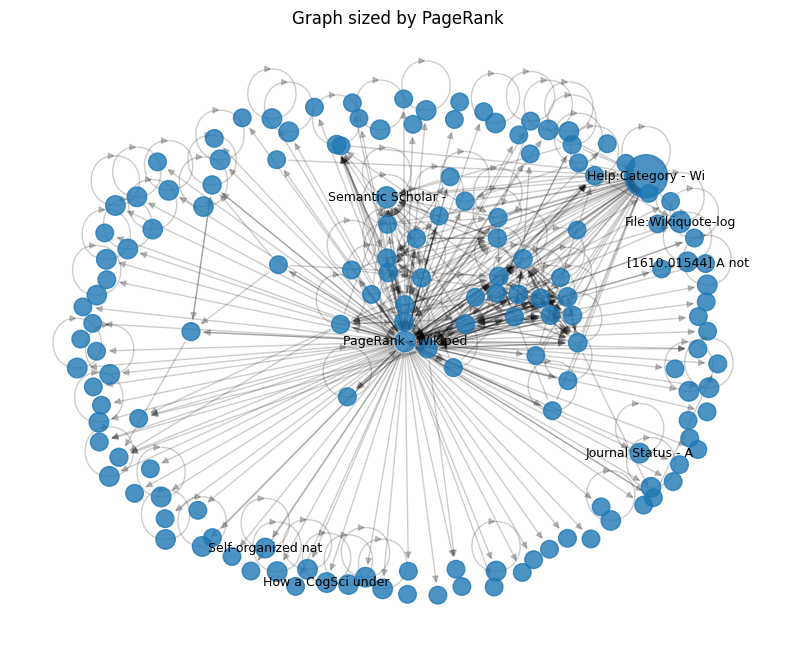

In [11]:
def draw_graph(G, measure_dict=None, title="Web Graph"):
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42, k=0.6)
    node_sizes = []
    for n in G.nodes():
        s = (measure_dict.get(n, 0.01) if measure_dict else 0.02)
        node_sizes.append(800 * (0.2 + s))

    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, alpha=0.8)
    nx.draw_networkx_edges(G, pos, arrows=True, alpha=0.2)
    # small labels for top nodes
    if measure_dict:
        top_nodes = [u for u, _ in sorted(measure_dict.items(), key=lambda x: x[1], reverse=True)[:8]]
        labels = {u: pages[u]["title"][:18] for u in top_nodes}
        nx.draw_networkx_labels(G, pos, labels=labels, font_size=9)
    plt.title(title)
    plt.axis("off")
    plt.show()

# Example: visualize PageRank sizing
draw_graph(G, measure_dict=pagerank_norm, title="Graph sized by PageRank")


# **🔎 Step 10 — Interactive Search UI (ipywidgets)**

In [12]:
algo_dd = widgets.Dropdown(
    options=[("Content+PageRank", "pagerank"),
             ("Content+HITS (Authority)", "hits_authority"),
             ("Content+HITS (Hub)", "hits_hub"),
             ("Content Only", "none")],
    value="pagerank",
    description="Rank by:"
)
alpha_sl = widgets.FloatSlider(
    value=RANK_COMBINE_ALPHA, min=0.0, max=1.0, step=0.05,
    description="α (content)",
    continuous_update=False
)
query_tb = widgets.Text(
    value="page rank algorithm",
    description="Query:",
    placeholder="type your query…",
    layout=widgets.Layout(width="70%")
)
topk_int = widgets.IntSlider(value=TOPK_RESULTS, min=3, max=30, step=1, description="TopK")

btn = widgets.Button(description="Search", button_style="primary")
out = widgets.Output()

def on_search_clicked(b):
    out.clear_output()
    q = query_tb.value.strip()
    if not q:
        with out:
            display(HTML("<b>Please type a query.</b>"))
        return
    algo = algo_dd.value
    alpha = alpha_sl.value
    results = combined_search(q, algo=algo, alpha=alpha, topk=topk_int.value, method="bm25")

    with out:
        rows = []
        for rank, (u, s) in enumerate(results, start=1):
            rec = pages[u]
            snippet = highlight_snippet(rec["text"], q, max_len=220)
            linkscore = {
                "pagerank": pagerank_raw.get(u, 0.0),
                "hits_authority": hits_auth_raw.get(u, 0.0) if 'hits_auth_raw' in globals() else 0.0,
                "hits_hub": hits_hubs_raw.get(u, 0.0) if 'hits_hubs_raw' in globals() else 0.0,
                "none": 0.0
            }[algo]
            html = f"""
            <div style="margin:10px 0;padding:10px;border:1px solid #ddd;border-radius:8px">
              <div><b>{rank}. <a href="{u}" target="_blank">{rec['title']}</a></b></div>
              <div style="font-size:12px;color:#555">{u}</div>
              <div style="margin-top:6px">{snippet}</div>
              <div style="margin-top:6px;color:#666;font-size:12px">
                Combined Score: {s:.4f} &nbsp;|&nbsp; Link Score: {linkscore:.4f}
              </div>
            </div>
            """
            display(HTML(html))
        if not results:
            display(HTML("<i>No results found.</i>"))

btn.on_click(on_search_clicked)
ui = widgets.VBox([query_tb, widgets.HBox([algo_dd, alpha_sl, topk_int, btn]), out])
display(ui)


# **💾 Step 11 — Save & Load Artifacts (for submission)**

In [13]:
import os, pickle

os.makedirs("artifacts", exist_ok=True)

def save_everything(prefix="mini_search_engine"):
    # Save pages
    with open(f"artifacts/{prefix}_pages.json", "w", encoding="utf-8") as f:
        json.dump(pages, f, ensure_ascii=False, indent=2)

    # Save URL order and titles
    with open(f"artifacts/{prefix}_urls.json", "w", encoding="utf-8") as f:
        json.dump({"urls": url_list, "titles": titles}, f, ensure_ascii=False, indent=2)

    # Save graph edge list
    edgelist = list(G.edges())
    with open(f"artifacts/{prefix}_edges.json", "w", encoding="utf-8") as f:
        json.dump(edgelist, f, ensure_ascii=False, indent=2)

    # Save rankings and vectorizer + TF-IDF matrix (as pickles)
    with open(f"artifacts/{prefix}_pagerank.pkl", "wb") as f:
        pickle.dump(pagerank_raw, f)
    with open(f"artifacts/{prefix}_hits.pkl", "wb") as f:
        pickle.dump({"hubs": hits_hubs_raw if 'hits_hubs_raw' in globals() else {},
                     "auth": hits_auth_raw if 'hits_auth_raw' in globals() else {}}, f)
    with open(f"artifacts/{prefix}_vectorizer.pkl", "wb") as f:
        pickle.dump(vectorizer, f)
    with open(f"artifacts/{prefix}_tfidf.npz", "wb") as f:
        pickle.dump(X, f)

    print("Saved to 'artifacts/'.")

def load_everything(prefix="mini_search_engine"):
    global pages, url_list, titles, G
    global pagerank_raw, hits_hubs_raw, hits_auth_raw
    global vectorizer, X

    with open(f"artifacts/{prefix}_pages.json", "r", encoding="utf-8") as f:
        pages = json.load(f)
    with open(f"artifacts/{prefix}_urls.json", "r", encoding="utf-8") as f:
        meta = json.load(f)
        url_list, titles = meta["urls"], meta["titles"]
    with open(f"artifacts/{prefix}_edges.json", "r", encoding="utf-8") as f:
        edgelist = json.load(f)
    G = nx.DiGraph()
    G.add_nodes_from(url_list)
    G.add_edges_from(edgelist)

    with open(f"artifacts/{prefix}_pagerank.pkl", "rb") as f:
        pagerank_raw = pickle.load(f)
    with open(f"artifacts/{prefix}_hits.pkl", "rb") as f:
        hits = pickle.load(f)
        hits_hubs_raw = hits.get("hubs", {})
        hits_auth_raw = hits.get("auth", {})
    with open(f"artifacts/{prefix}_vectorizer.pkl", "rb") as f:
        vectorizer = pickle.load(f)
    with open(f"artifacts/{prefix}_tfidf.npz", "rb") as f:
        X = pickle.load(f)

    print("Loaded artifacts.")

# Save now (optional)
save_everything(SAVE_PREFIX)


Saved to 'artifacts/'.


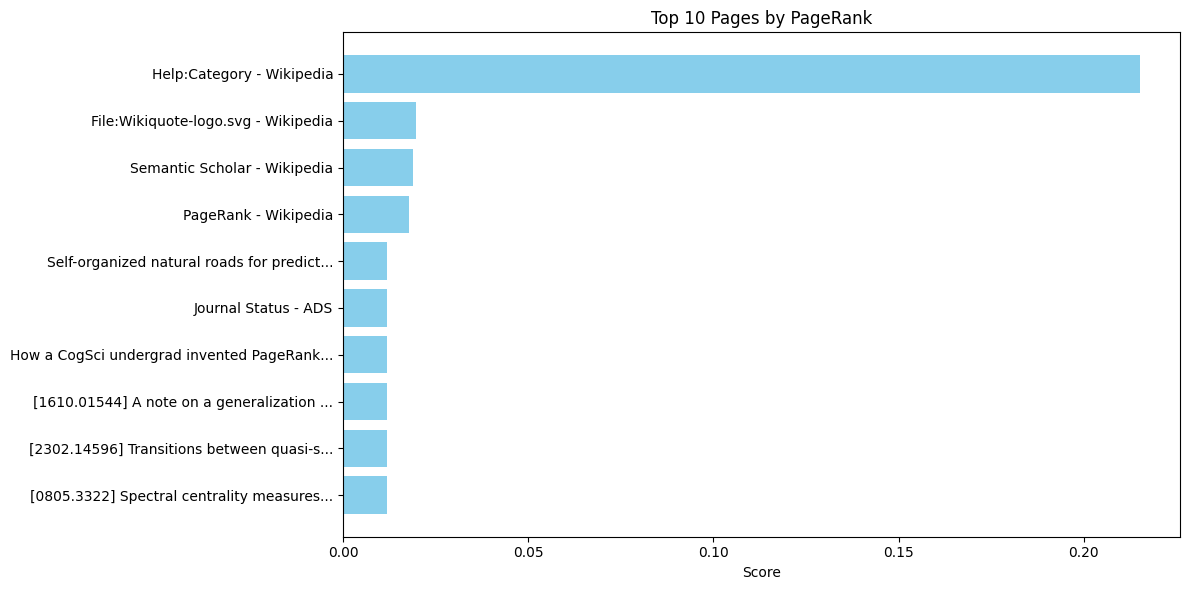

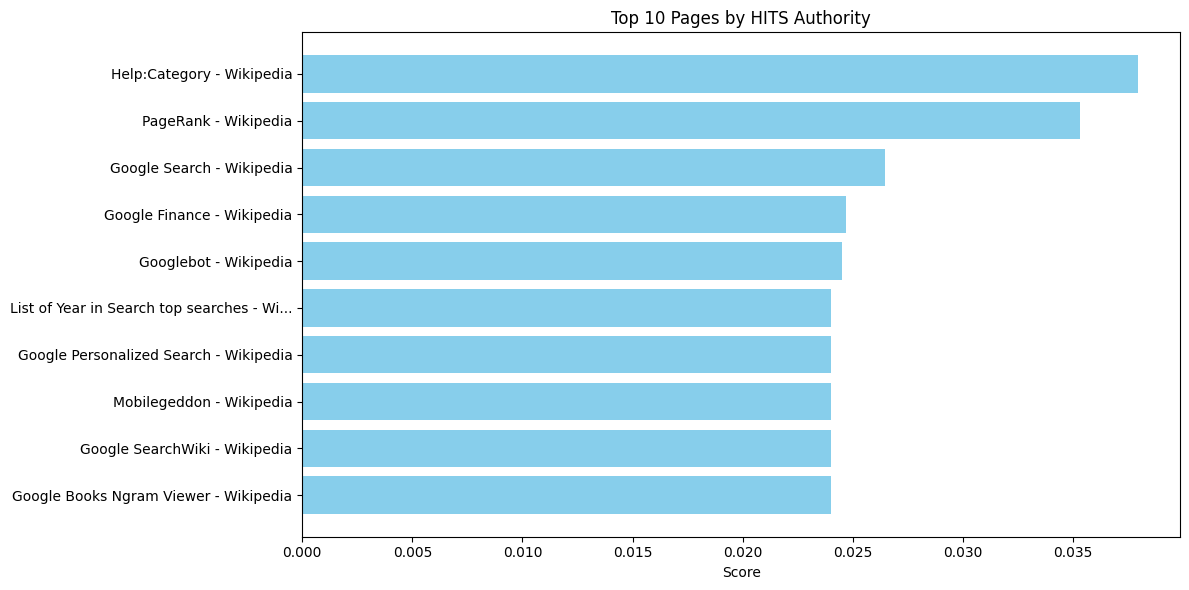

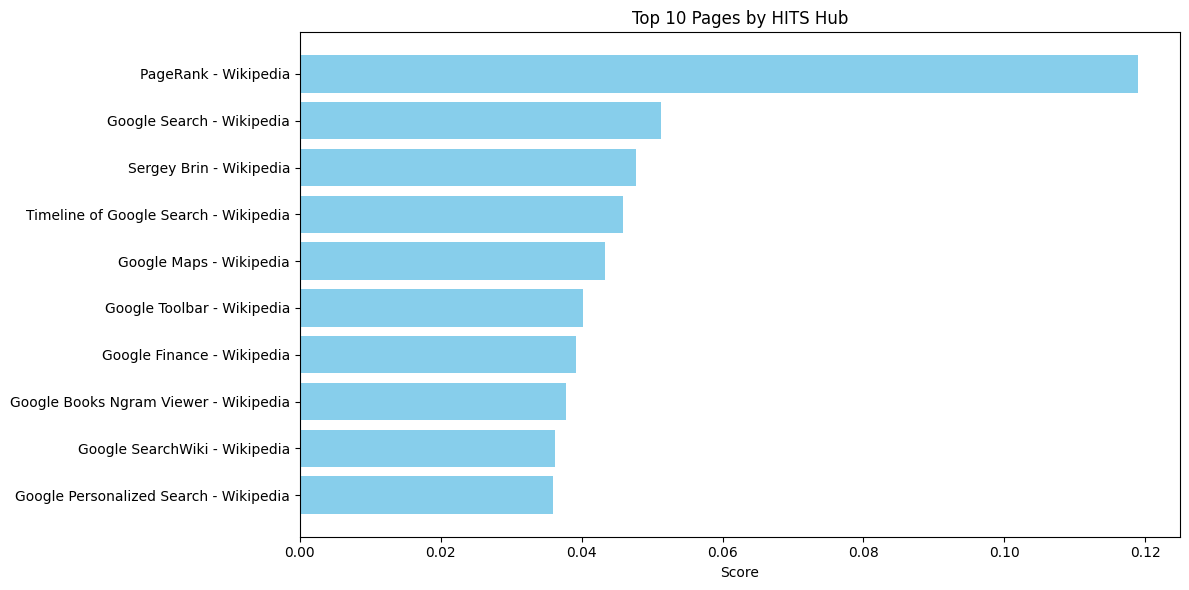

In [16]:
# --- Bar chart visualization of top ranked pages ---

def plot_top_ranks(rank_dict, title, k=10):
    """Plots a bar chart of the top k pages by rank."""
    top_items = sorted(rank_dict.items(), key=lambda x: x[1], reverse=True)[:k]
    if not top_items:
        print(f"No data to plot for {title}")
        return

    urls, scores = zip(*top_items)
    # Get short titles or URLs for labels
    labels = [pages[u]["title"][:40] + '...' if len(pages[u]["title"]) > 40 else pages[u]["title"] for u in urls]

    plt.figure(figsize=(12, 6))
    plt.barh(labels[::-1], scores[::-1], color='skyblue')
    plt.xlabel("Score")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Plot top PageRank scores
plot_top_ranks(pagerank_raw, "Top 10 Pages by PageRank", k=10)

# Plot top HITS Authority scores (if available)
if 'hits_auth_raw' in globals() and hits_auth_raw:
    plot_top_ranks(hits_auth_raw, "Top 10 Pages by HITS Authority", k=10)

# Plot top HITS Hub scores (if available)
if 'hits_hubs_raw' in globals() and hits_hubs_raw:
     plot_top_ranks(hits_hubs_raw, "Top 10 Pages by HITS Hub", k=10)

# **✅ Step 12 — How to Present / What to Show**

* Show the DataFrame (df_pages.head()) to prove you crawled pages (or used the
demo set).

* Show top PageRank / HITS nodes printed in Step 6.

* Show the graph viz (Step 9).

* Use the interactive search box (Step 10):

* Try different queries (e.g., “authority”, “algorithm”, “web mining”)

* Switch between Content+PageRank and Content+HITS

* Adjust α (content weight) and show how ranking changes

* Mention that scores combine content & link: Combined = α*TFIDF + (1-α)*LinkScore.

* Provide the artifacts folder as your submission (JSON + pickles).

# **🙋 FAQs (quick)**

* Can this be done entirely in Colab? Yes. You already have a full notebook.

* No internet in class? Set ONLINE_CRAWL = False (offline demo).

* More pages? Increase MAX_PAGES (keep it reasonable).

* Only Wikipedia? Change SEED_URLS and set SAME_DOMAIN_ONLY=False (but crawl responsibly).